# Chapter 3 - linear neural networks

### Imports

In [1]:
import pandas as pd

## Linear regression

In [21]:
%matplotlib inline
from d2l import torch as d2l
import math
import torch
import numpy as np
import time
import random

In [3]:
n = 10000
a = torch.ones(n)
b = torch.ones(n)

In [4]:
def normal(x, mu, sigma):
    p = 1 / math.sqrt(2 * math.pi * sigma**2)
    return p * np.exp(-0.5 / sigma**2 * (x - mu)**2)

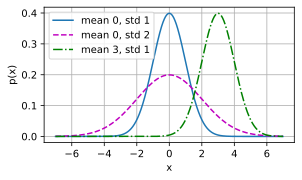

In [5]:
# Use numpy again for visualization
x = np.arange(-7, 7, 0.01)

# Mean and standard deviation pairs
params = [(0, 1), (0, 2), (3, 1)]
d2l.plot(x, [normal(x, mu, sigma) for mu, sigma in params], xlabel='x',
         ylabel='p(x)', figsize=(4.5, 2.5),
         legend=[f'mean {mu}, std {sigma}' for mu, sigma in params])

## Linear Regression Implementation from Scratch

In [170]:
def synthetic_data(w, b, num_examples):  #@save
    """Generate y = Xw + b + noise."""
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape((-1, 1))

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

In [171]:
print('features:', features[0],'\nlabel:', labels[0])

features: tensor([-1.3123, -1.8417]) 
label: tensor([7.8246])


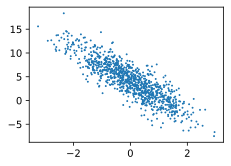

In [172]:
d2l.set_figsize()
# The semicolon is for displaying the plot only
d2l.plt.scatter(d2l.numpy(features[:, 1]), d2l.numpy(labels), 1);

In [173]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    # The examples are read at random, in no particular order
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(
            indices[i: min(i + batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]

In [174]:
# initialise weights - Notice the requires grad which allows for auto diff
w = torch.normal(0, 0.01, size=(2,1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

In [175]:
def linreg(X, w, b):
    """The linear regression model."""
    return torch.matmul(X, w) + b

def squared_loss(y_hat, y):  #@save
    """Squared loss."""
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

In [176]:
# Stochastic gradient descent!
def sgd(params, lr, batch_size):  #@save
    """Minibatch stochastic gradient descent.
    
    The parameters are updated using the
    data and inplace subtract. The data attribute
    ensures that the operation is not tracked
    """
    
    for param in params:
        param.data.sub_(lr*param.grad/batch_size)
        param.grad.data.zero_()

In [177]:
# # why we need .data
# l = loss(net(X, w, b), y)  # Minibatch loss in `X` and `y`
# # Compute gradient on `l` with respect to [`w`, `b`]
# l.sum().backward()

# w

# w.grad

# w.sub_(lr*w.grad/batch_size)

In [178]:
batch_size = 10
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y)  # Minibatch loss in `X` and `y`
        # Compute gradient on `l` with respect to [`w`, `b`]
        l.sum().backward()
        sgd([w, b], lr, batch_size)  # Update parameters using their gradient
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

epoch 1, loss 0.035860
epoch 2, loss 0.000133
epoch 3, loss 0.000050


In [179]:
# with torch.no_grad():
print(f'error in estimating w: {true_w - w.reshape(true_w.shape)}')
print(f'error in estimating b: {true_b - b}')

error in estimating w: tensor([-9.2506e-05, -1.4114e-04], grad_fn=<SubBackward0>)
error in estimating b: tensor([0.0008], grad_fn=<RsubBackward1>)


## Concise linear regression

In [181]:
from d2l import torch as d2l
import numpy as np
import torch
from torch.utils import data

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = d2l.synthetic_data(true_w, true_b, 1000)

In [206]:
def load_array(data_arrays, batch_size, is_train=True):  #@save
    """Construct a PyTorch data iterator."""
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)

batch_size = 10
data_iter = load_array((features, labels), batch_size)

In [208]:
# next(iter(data_iter))

In [232]:
# `nn` is an abbreviation for neural networks
from torch import nn
net = nn.Sequential(nn.Linear(2, 1))

In [233]:
# initialise values of net
net[0].weight.data.normal_(0, 0.01)
net[0].bias.data.fill_(0)

tensor([0.])

In [234]:
loss = nn.MSELoss()
trainer = torch.optim.SGD(net.parameters(), lr=0.03)

In [235]:
num_epochs = 3
for epoch in range(num_epochs):
    for X, y in data_iter:
        l = loss(net(X) ,y)
        trainer.zero_grad()
        l.backward()
        trainer.step()
    l = loss(net(features), labels)
    print(f'epoch {epoch + 1}, loss {l:f}')

epoch 1, loss 0.000197
epoch 2, loss 0.000100
epoch 3, loss 0.000100


In [236]:
w = net[0].weight.data
print('error in estimating w:', true_w - w.reshape(true_w.shape))
b = net[0].bias.data
print('error in estimating b:', true_b - b)

error in estimating w: tensor([0.0004, 0.0003])
error in estimating b: tensor([-0.0001])
